# Import & data load

In [1]:
# Google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import sys
import seaborn as sns # 데이터 시각화 라이브러리
import matplotlib.pyplot as plt # 그래프 라이브러리
import missingno as msno

# 경고 무시 설정
import warnings
warnings.filterwarnings('ignore')
# 그래프 인라인 표시 명령어
%matplotlib inline

In [3]:
# 환경마다 설정 잘 하기
ROOT_DIR = "/content/drive/MyDrive/HackJun/data"
RANDOM_STATE = 110  # 고정

In [4]:
# Load data
df_train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"), low_memory=False)

# 데이터 기본 처리

- Normal / AbNormal 비율 확인 <br> = 94.2 : 5.8

<Axes: ylabel='count'>

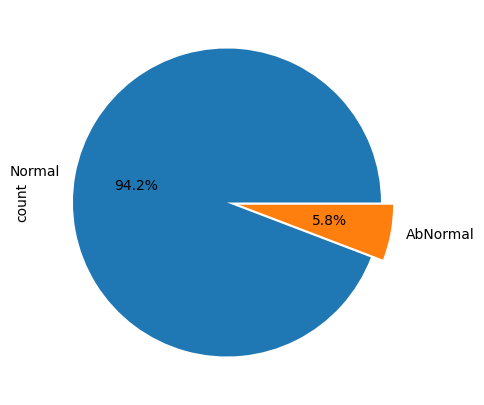

In [18]:
df_train["target"].value_counts()

plt.figure(figsize=(8, 5))  # 그래프의 크기를 가로 8인치, 세로 5인치로 설정
labels = ['Normal', 'AbNormal']  # 파이 차트의 각 섹션에 대한 레이블을 설정

df_train['target'].value_counts().plot.pie(
    explode=[0, 0.08],
    autopct='%1.1f%%',
    labels=labels
)

## 결측치 절반 이상 칼럼 삭제

In [5]:
print(len(df_train.notnull().sum() // 2))

464


In [6]:
# 결측치가 절반 이상인 열을 찾기 위한 리스트
drop_cols = []
for column in df_train.columns:
    # 각 열의 결측치가 절반 이상이면 해당 열의 이름을 drop_cols 리스트에 추가
    if (df_train[column].notnull().sum() // 2) < df_train[
        column
    ].isnull().sum():
        drop_cols.append(column)

In [7]:
print(len(drop_cols))

283


In [8]:
# 제거
df_drop = df_train.drop(drop_cols, axis=1)

## 단일값 칼럼 삭제

In [10]:
columns_with_single_value = [col for col in df_drop.columns if df_drop[col].nunique() == 1]

In [11]:
# 제거
df_drop = df_drop.drop(columns=columns_with_single_value)

## 결측값(절반 이하) 칼럼 확인 & 처리

<Axes: >

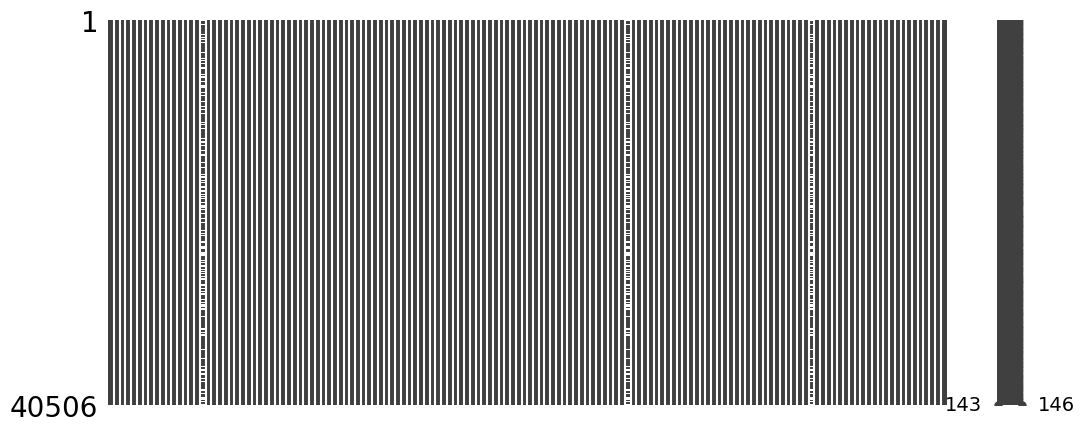

In [12]:
# 결측치 시각화
msno.matrix(df_drop, figsize=(12, 5))

In [13]:
columns_with_missing_values = df_drop.columns[df_drop.isnull().any()].tolist()
columns_with_missing_values

['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2']

In [14]:
# 비율
missing_values_percentage = df_drop[columns_with_missing_values].isnull().mean() * 100
missing_values_percentage

,0
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,31.516319
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,31.516319
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2,31.516319


In [15]:
# 각 칼럼에서 결측치가 발생한 행의 인덱스 추출
missing_indices = [set(df_drop[df_drop[col].isnull()].index) for col in columns_with_missing_values]
# 모든 칼럼에서 결측치가 발생한 행이 같은지 확인
all_missing_indices_same = all(indices == missing_indices[0] for indices in missing_indices)
# 결과 출력
print("결측치 발생 행 index 동일 여부 : ", all_missing_indices_same)

결측치 발생 행 index 동일 여부 :  True


In [16]:
# 결측값이 존재하는 행들의 인덱스 추출
rows_with_missing_values = df_drop[df_drop[columns_with_missing_values].isnull().any(axis=1)].index
# 결측치 존재 행의 target 값들
target_values_for_missing_indices = df_drop.loc[rows_with_missing_values, 'target']
# 'target' 값 비율 계산
target_value_counts = target_values_for_missing_indices.value_counts(normalize=True) * 100
print(target_value_counts)

target
Normal      94.924017
AbNormal     5.075983
Name: proportion, dtype: float64


결측치 칼럼 제거 근거
- 95:5 비율은 전체 데이터세트의 결측치 비율과 거의 동일. 삭제해도 비율상 동일 유지 기대
- "완전성 품질 지수"에 의거하여 30% 이상의 결측치 보유 칼럼 삭제

In [17]:
# 제거
df_drop = df_drop.drop(columns=columns_with_missing_values)

# 범주형

In [19]:
# 범주형 변수 식별
categorical_feats = df_drop.select_dtypes(include=['object']).columns

In [20]:
categorical_feats

Index(['Equipment_Dam', 'Model.Suffix_Dam', 'Workorder_Dam',
       'Model.Suffix_AutoClave', 'Workorder_AutoClave',
       'Chamber Temp. Judge Value_AutoClave', 'Equipment_Fill1',
       'Model.Suffix_Fill1', 'Workorder_Fill1', 'Equipment_Fill2',
       'Model.Suffix_Fill2', 'Workorder_Fill2', 'target'],
      dtype='object')

In [21]:
# 값 분포 확인
for col in df_drop.select_dtypes(include='object').columns:
    print(f"Column '{col}' has {df_drop[col].nunique()} unique values.")

Column 'Equipment_Dam' has 2 unique values.
Column 'Model.Suffix_Dam' has 7 unique values.
Column 'Workorder_Dam' has 663 unique values.
Column 'Model.Suffix_AutoClave' has 7 unique values.
Column 'Workorder_AutoClave' has 663 unique values.
Column 'Chamber Temp. Judge Value_AutoClave' has 2 unique values.
Column 'Equipment_Fill1' has 2 unique values.
Column 'Model.Suffix_Fill1' has 7 unique values.
Column 'Workorder_Fill1' has 663 unique values.
Column 'Equipment_Fill2' has 2 unique values.
Column 'Model.Suffix_Fill2' has 7 unique values.
Column 'Workorder_Fill2' has 663 unique values.
Column 'target' has 2 unique values.


## Workorder 삭제
- 663 차원 너무 높음
- 이상치에 큰 영향 없을거란 판단

In [24]:
# 663로 나뉘는 Workorder
work_to_drop = ['Workorder_Dam', 'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2']
df_drop = df_drop.drop(columns=work_to_drop)

남은 범주형 변수 분포 및 이상치 비율 확인

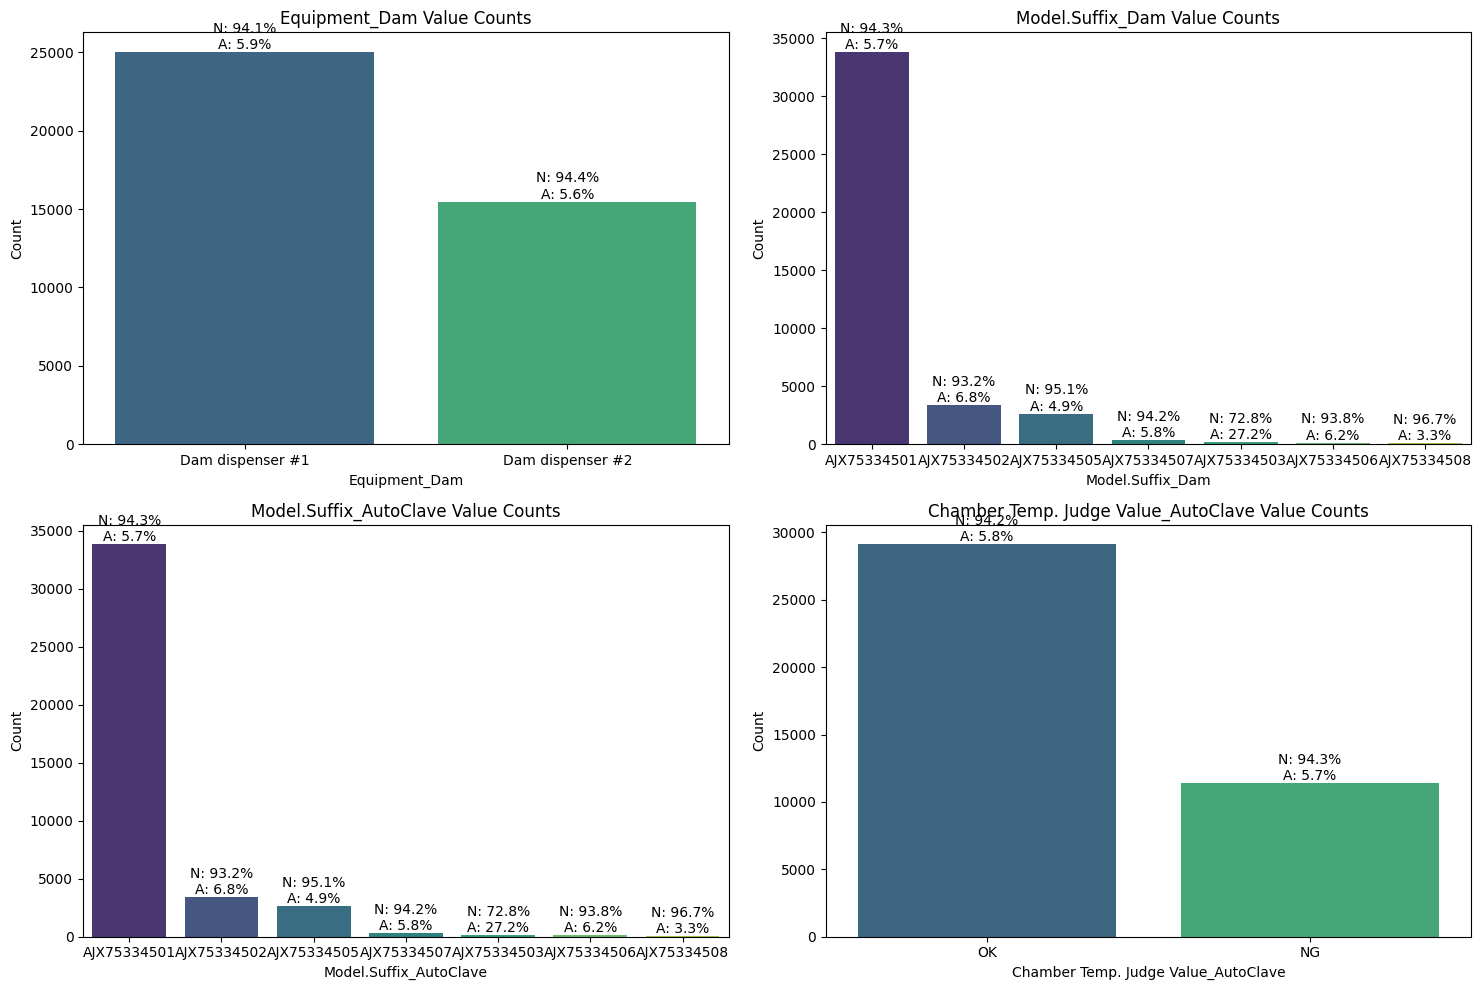

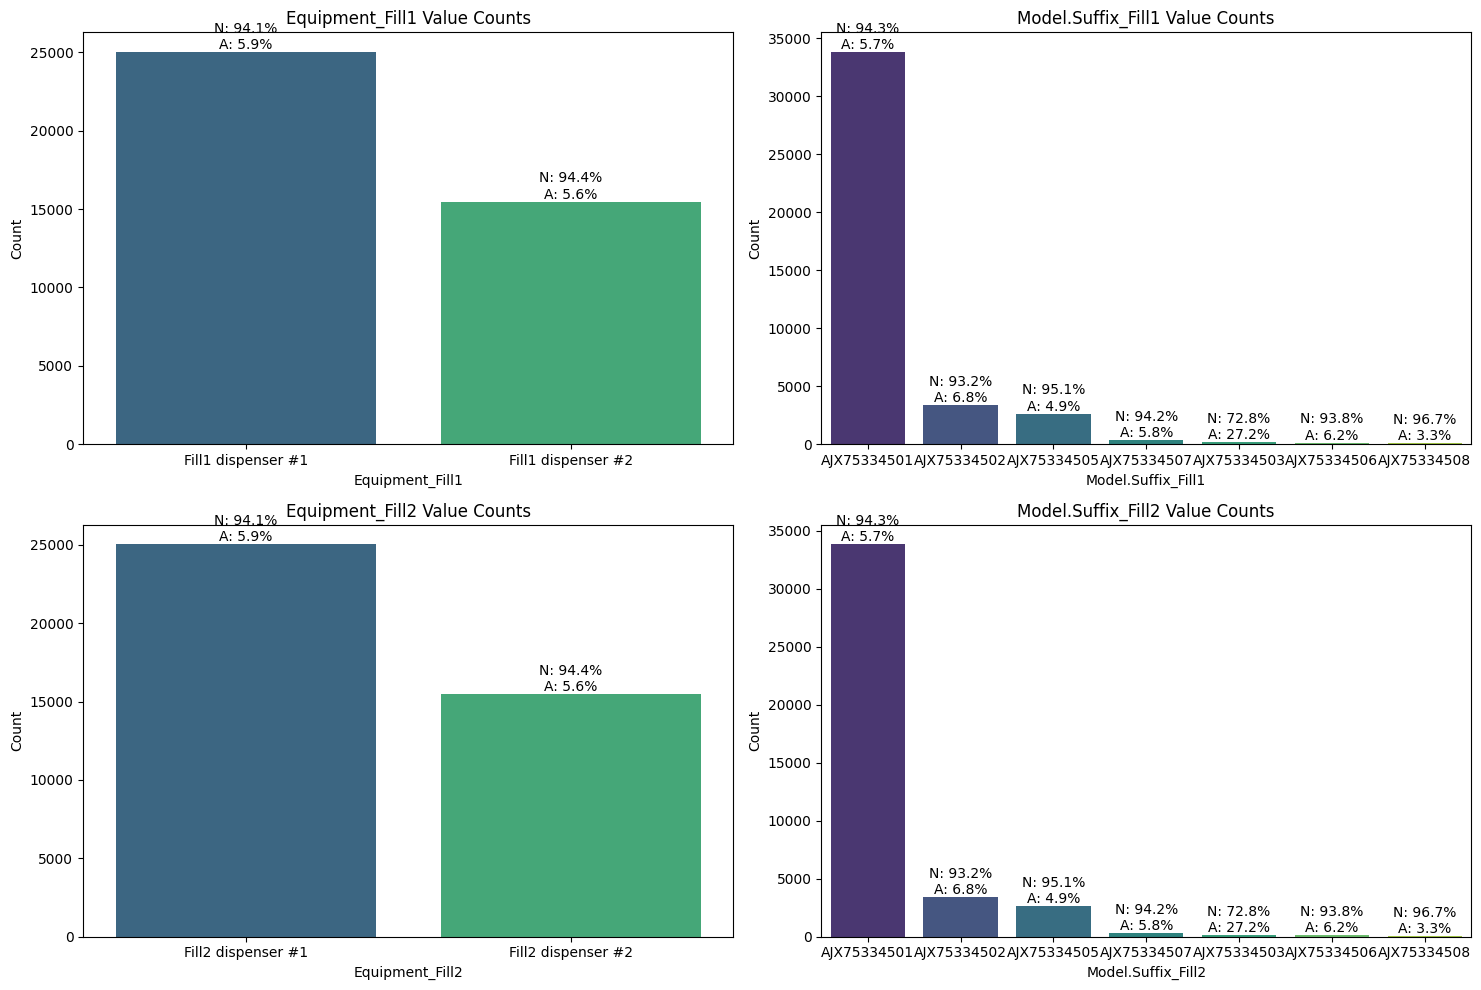

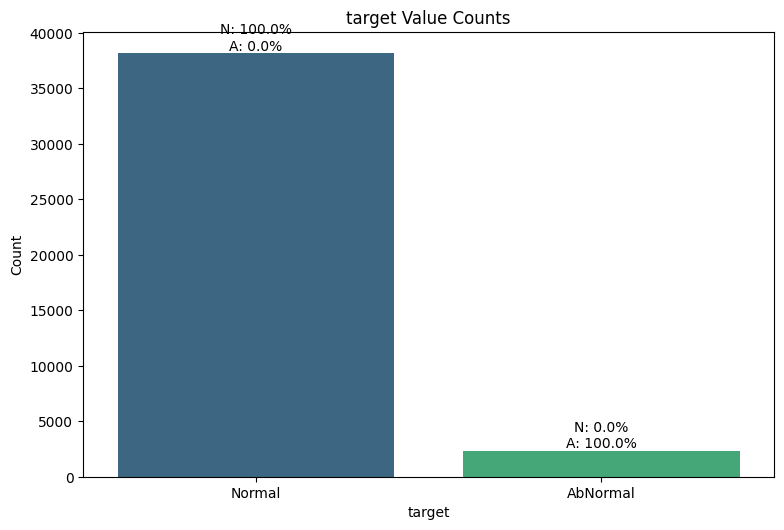

In [25]:
import math
categorical_feats = df_drop.select_dtypes(include=['object']).columns

# 그래프 당 열 개수
num_cols = 2
num_rows = 2

# 페이지 수 계산
num_pages = math.ceil(len(categorical_feats) / (num_cols * num_rows))

# 모든 범주형 변수에 대해 시각화
for page in range(num_pages):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(num_cols * num_rows):
        idx = page * (num_cols * num_rows) + i
        if idx < len(categorical_feats):
            col = categorical_feats[idx]
            count = df_drop[col].value_counts().reset_index()
            count.columns = [col, 'Count']
            sns.barplot(x=col, y='Count', data=count, ax=axes[i], palette='viridis')
            axes[i].set_title(f'{col} Value Counts')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')

            # 각 막대 위에 AbNormal/Normal 비율 추가
            for j, value in enumerate(count[col]):
                subset = df_drop[df_drop[col] == value]
                target_counts = subset['target'].value_counts(normalize=True) * 100
                normal_count = target_counts.get('Normal', 0)
                abnormal_count = target_counts.get('AbNormal', 0)
                axes[i].text(j, count['Count'][j], f'N: {normal_count:.1f}%\nA: {abnormal_count:.1f}%', ha='center', va='bottom')

            # axes[i].tick_params(axis='x', rotation=90)  # X축 라벨을 90도 회전하여 가독성 향상
        else:
            axes[i].set_visible(False)  # 불필요한 서브플롯 숨기기

    plt.tight_layout()
    plt.show()

## model.suffix 칼럼 통합

- 각 공정별 model.suffix값은 동일 row 동일 값이기에 하나로 통합 & 더미화

In [26]:
# model suffix values
model_suffixe_value = ['AJX75334501', 'AJX75334503', 'AJX75334502', 'AJX75334505', 'AJX75334506', 'AJX75334507', 'AJX75334508']

# one-hot encoding 추가
for suffix in model_suffixe_value:
    df_drop[suffix] = ((df_drop['Model.Suffix_Dam'] == suffix) &
                                 (df_drop['Model.Suffix_Fill1'] == suffix) &
                                 (df_drop['Model.Suffix_Fill2'] == suffix) &
                                 (df_drop['Model.Suffix_AutoClave'] == suffix)).astype(int)

# 'Model.Suffix - ' columns drop
df_drop.drop(columns=['Model.Suffix_Dam', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2', 'Model.Suffix_AutoClave'], inplace=True)


## Equipment 칼럼 더미화

- 특정 기계(Equipment, model.suffix) 조합이 결함에 영향을 준다는 가정

In [27]:
df_drop = pd.get_dummies(df_drop, columns=['Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2'])

In [28]:
# True / False -> 1 / 0
df_drop = df_drop.applymap(lambda x: 1 if x is True else (0 if x is False else x))

## Chamber Temp. Judge Value_AutoClave 칼럼 더미화

- OK / NG 값 0 / 1 변환

In [29]:
# 'Chamber Temp. Judge Value_AutoClave' 컬럼의 OK와 NG 값을 0과 1로 변환
df_drop['Chamber Temp. Judge Value_AutoClave'] = df_drop['Chamber Temp. Judge Value_AutoClave'].replace({'OK': 0, 'NG': 1})

# 수치형

In [30]:
df_drop.columns.tolist()

['CURE END POSITION X Collect Result_Dam',
 'CURE END POSITION Z Collect Result_Dam',
 'CURE END POSITION Θ Collect Result_Dam',
 'CURE SPEED Collect Result_Dam',
 'CURE START POSITION X Collect Result_Dam',
 'CURE START POSITION Θ Collect Result_Dam',
 'DISCHARGED SPEED OF RESIN Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
 'Dispense Volume(Stage1) Collect Result_Dam',
 'Dispense Volume(Stage2) Collect Result_Dam',
 'Dispense Volume(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
 'HEAD NORMAL COORDINAT

## Violin Plot

In [45]:
# 'target' 칼럼과 0, 1값만(더미화) 존재하는 칼럼 제외한 칼럼 목록
all_columns = [col for col in df_drop.columns if col != 'target' and (df_drop[col].nunique() > 2 or not set(df_drop[col].unique()).issubset({0, 1}))]

# 총 필요한 그래프의 수
num_cols = 5  # 한 행에 표시할 그래프의 수
num_rows = -(-len(all_columns) // num_cols)  # 올림 계산

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # 축을 평평하게 펼침

# 각 칼럼에 대해 바이올린 플롯 그리기
for i, col in enumerate(all_columns):
    sns.violinplot(x='target', y=col, data=df_drop, ax=axes[i])

# 남은 빈 그래프를 삭제
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## .describe

In [46]:
df_drop[all_columns].describe()

,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,...,Head Clean Position Y Collect Result_Fill2,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2
count,40506.000000,40506.000000,40506.000000,40506.000000,40506.000000,40506.000000,40506.000000,40506.000000,40506.000000,40506.000000,...,40506.000000,40506.000000,40506.000000,40506.000000,40506.000000,40506.000000,40506.000000,40506.000000,40506.000000,40506.000000
mean,530.370809,6.320669,-21.227966,73.864119,743.449859,-21.227966,12.882437,14.272249,6.861304,14.262638,...,90.983336,66.972414,164.156081,180.671505,64.211351,62.048909,14.385928,73.539648,108.691453,0.771392
std,369.283055,4.858988,87.461776,9.761997,364.424068,87.461776,2.997650,3.743857,1.994393,3.733232,...,33.885760,20.527895,87.513657,108.041552,17.188429,36.466634,7.261448,105.176311,130.758018,1.289203
min,240.000000,2.500000,-90.000000,70.000000,280.000000,-90.000000,10.000000,9.600000,3.800000,9.600000,...,50.000000,50.000000,91.800000,50.000000,50.000000,17.600000,1.000000,0.000000,0.000000,0.000000
25%,240.000000,2.500000,-90.000000,70.000000,280.000000,-90.000000,10.000000,13.100000,4.900000,13.100000,...,50.000000,50.000000,91.800000,50.000000,50.000000,19.600000,7.000000,7.000000,1.000000,0.000000
50%,240.000000,2.500000,-90.000000,70.000000,1030.000000,-90.000000,10.000000,13.200000,6.700000,13.200000,...,119.000000,50.000000,91.800000,270.000000,50.000000,85.000000,19.500000,13.000000,49.000000,1.000000
75%,1000.000000,12.500000,90.000000,70.000000,1030.000000,90.000000,16.000000,17.000000,8.400000,17.000000,...,119.000000,91.800000,270.000000,270.000000,85.000000,85.000000,19.900000,120.000000,196.000000,1.000000
max,1000.000000,12.500000,90.000000,105.000000,1030.000000,90.000000,16.000000,21.300000,10.600000,21.400000,...,119.000000,91.800000,270.000000,270.000000,85.000000,284.100000,52.900000,487.000000,608.000000,17.000000


# TSNE

In [47]:
from sklearn.manifold import TSNE  # 고차원 데이터를 저차원으로 시각화하기 위해 사용

def tsne_plot(x1, y1, name="graph.png"):  # t-SNE 시각화를 수행하는 함수 정의, x1은 입력 데이터, y1은 레이블, name은 저장될 파일 이름
    tsne = TSNE(n_components=2, random_state=110)  # t-SNE 객체 생성, 2차원으로 변환, 결과의 재현성을 위해 random_state 설정
    X_t = tsne.fit_transform(x1)  # 입력 데이터 x1을 t-SNE를 사용하여 2차원으로 변환

    plt.figure(figsize=(12, 8))  # 새로운 그림(figure) 생성, 크기는 12x8 인치
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', alpha=0.8, label='Normal')  # Normal 녹색으로 표시
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', alpha=0.8, label='AbNormal')  # AbNormal 빨간색으로 표시

    plt.legend(loc='best')  # 최적의 위치에 범례 표시
    plt.show();

In [49]:
# target 칼럼 마지막 배치
if 'target' in df_drop.columns:
    target_col = df_drop.pop('target')
    df_drop['target'] = target_col
    df_drop['target'] = df_drop['target'].map({'Normal': 0, 'AbNormal': 1})

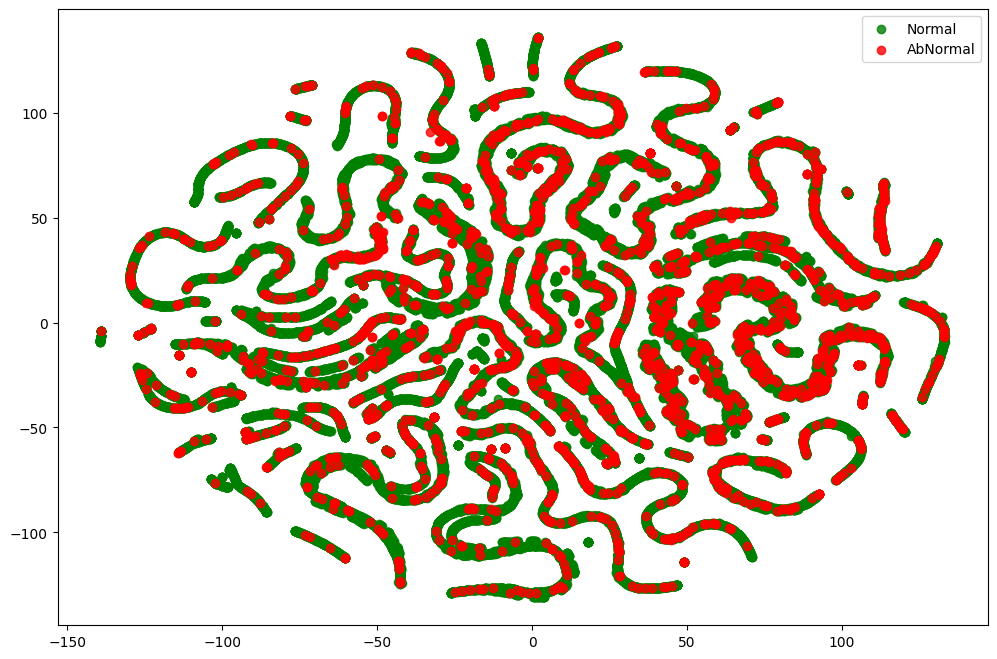

In [51]:
# 기본 데이터로
tsne_plot(df_drop.drop(['target'], axis = 1).values, df_drop["target"].values, "TSNE.png")

- 매우 비선형적으로 보임